# Employee future prediction
- Il dipartimento HR di una società ha il compito di predire il futuro degli impiegati cercando di capire chi lascerà o meno la società nei due anni successivi.
- Problema di apprendimento supervisionato.
- Si tratta di classificazione binaria.
- Obiettivo: trovare il miglior modello predittivo per individuare coloro che abbandoneranno. 

In [1]:
# importo le librerie utili al data preprocessing
import os
import pandas as pd
import numpy as np
import pickle

# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
# Math and Stat modules
import numpy as np
from scipy.special import logit, expit
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix


In [2]:
# importo il dataset 
employee_dataset = pd.read_csv('data/Employee.csv')

In [3]:
employee_dataset

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


# 1. Analisi descrittiva

In [4]:
# osserviamo che non sono presenti dati nulli, quindi non ci sarà bisogno di utilizzare un imputer
employee_dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [5]:
# valori possibili per ogni feature
for i in employee_dataset.columns:
    print(employee_dataset[i].value_counts())

Bachelors    3601
Masters       873
PHD           179
Name: Education, dtype: int64
2017    1108
2015     781
2014     699
2013     669
2016     525
2012     504
2018     367
Name: JoiningYear, dtype: int64
Bangalore    2228
Pune         1268
New Delhi    1157
Name: City, dtype: int64
3    3492
2     918
1     243
Name: PaymentTier, dtype: int64
26    645
28    630
27    625
25    418
24    385
29    230
30    220
37    141
36    139
34    136
38    136
40    134
32    132
39    131
31    125
33    124
35    123
41     82
22     49
23     48
Name: Age, dtype: int64
Male      2778
Female    1875
Name: Gender, dtype: int64
No     4175
Yes     478
Name: EverBenched, dtype: int64
2    1087
4     931
5     919
3     786
1     558
0     355
7       9
6       8
Name: ExperienceInCurrentDomain, dtype: int64
0    3053
1    1600
Name: LeaveOrNot, dtype: int64


In [6]:
#trasformazione paymenttier da variabile numerica a variabile categoriale
employee_dataset['PaymentTier']= employee_dataset['PaymentTier'].map(
    {1: 'Low' ,
     2: 'Mid',
     3: 'High'
    }
)

| Nome colonna | Significato| Range |
| --- | --- | --- |
|Education| Livello di istruzione dell'impiegato| 'Bachelors', 'Masters', 'PHD' |
|JoiningYear| Indica l'anno di assunzione | 2012 : 2018 |
|City| Indica la città dell'ufficio | 'Bangalore', 'New Delhi', 'Pune' |
|PaymentTier| Livello di stipendio| 'Low' , 'Mid', 'High' |
|Age |Età del dipendente| 22 : 41 |
|Gender| Genere del cliente| 'Female', 'Male' |
|EverBenched| Se il dipendente è rimasto escluso dai progetti per più di un mese| 'No', 'Yes' |
|ExperienceInCurrentDomain| Anni di esperienza nel settore| 0 : 7 |
|LeaveOrNot| Label: 1 se il dipendente lascia la società, 0 se non lascia| 0, 1 |

In [7]:
employee_dataset.describe()

,JoiningYear,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,29.393295,2.905652,0.343864
std,1.863377,4.826087,1.558240,0.475047
min,2012.000000,22.000000,0.000000,0.000000
25%,2013.000000,26.000000,2.000000,0.000000
50%,2015.000000,28.000000,3.000000,0.000000
75%,2017.000000,32.000000,4.000000,1.000000
max,2018.000000,41.000000,7.000000,1.000000


In [8]:
#definizione della funzione per i grafici
def n_plot (df,x_size= 30,y_size=30,*args,**kwargs ):
    fig, axes = plt.subplots(nrows=3, ncols=3, 
                             figsize=(x_size,y_size)
                            )
    axes = axes.flatten()
    
    for i, j in zip(df.columns, axes):
        if i!= 'PaymentTier':
            sns.countplot(data=df, x=i,ax=j, *args,**kwargs)
        else:
            sns.countplot(data=df, x=i,ax=j, order=['Low', 'Mid','High'], *args,**kwargs)


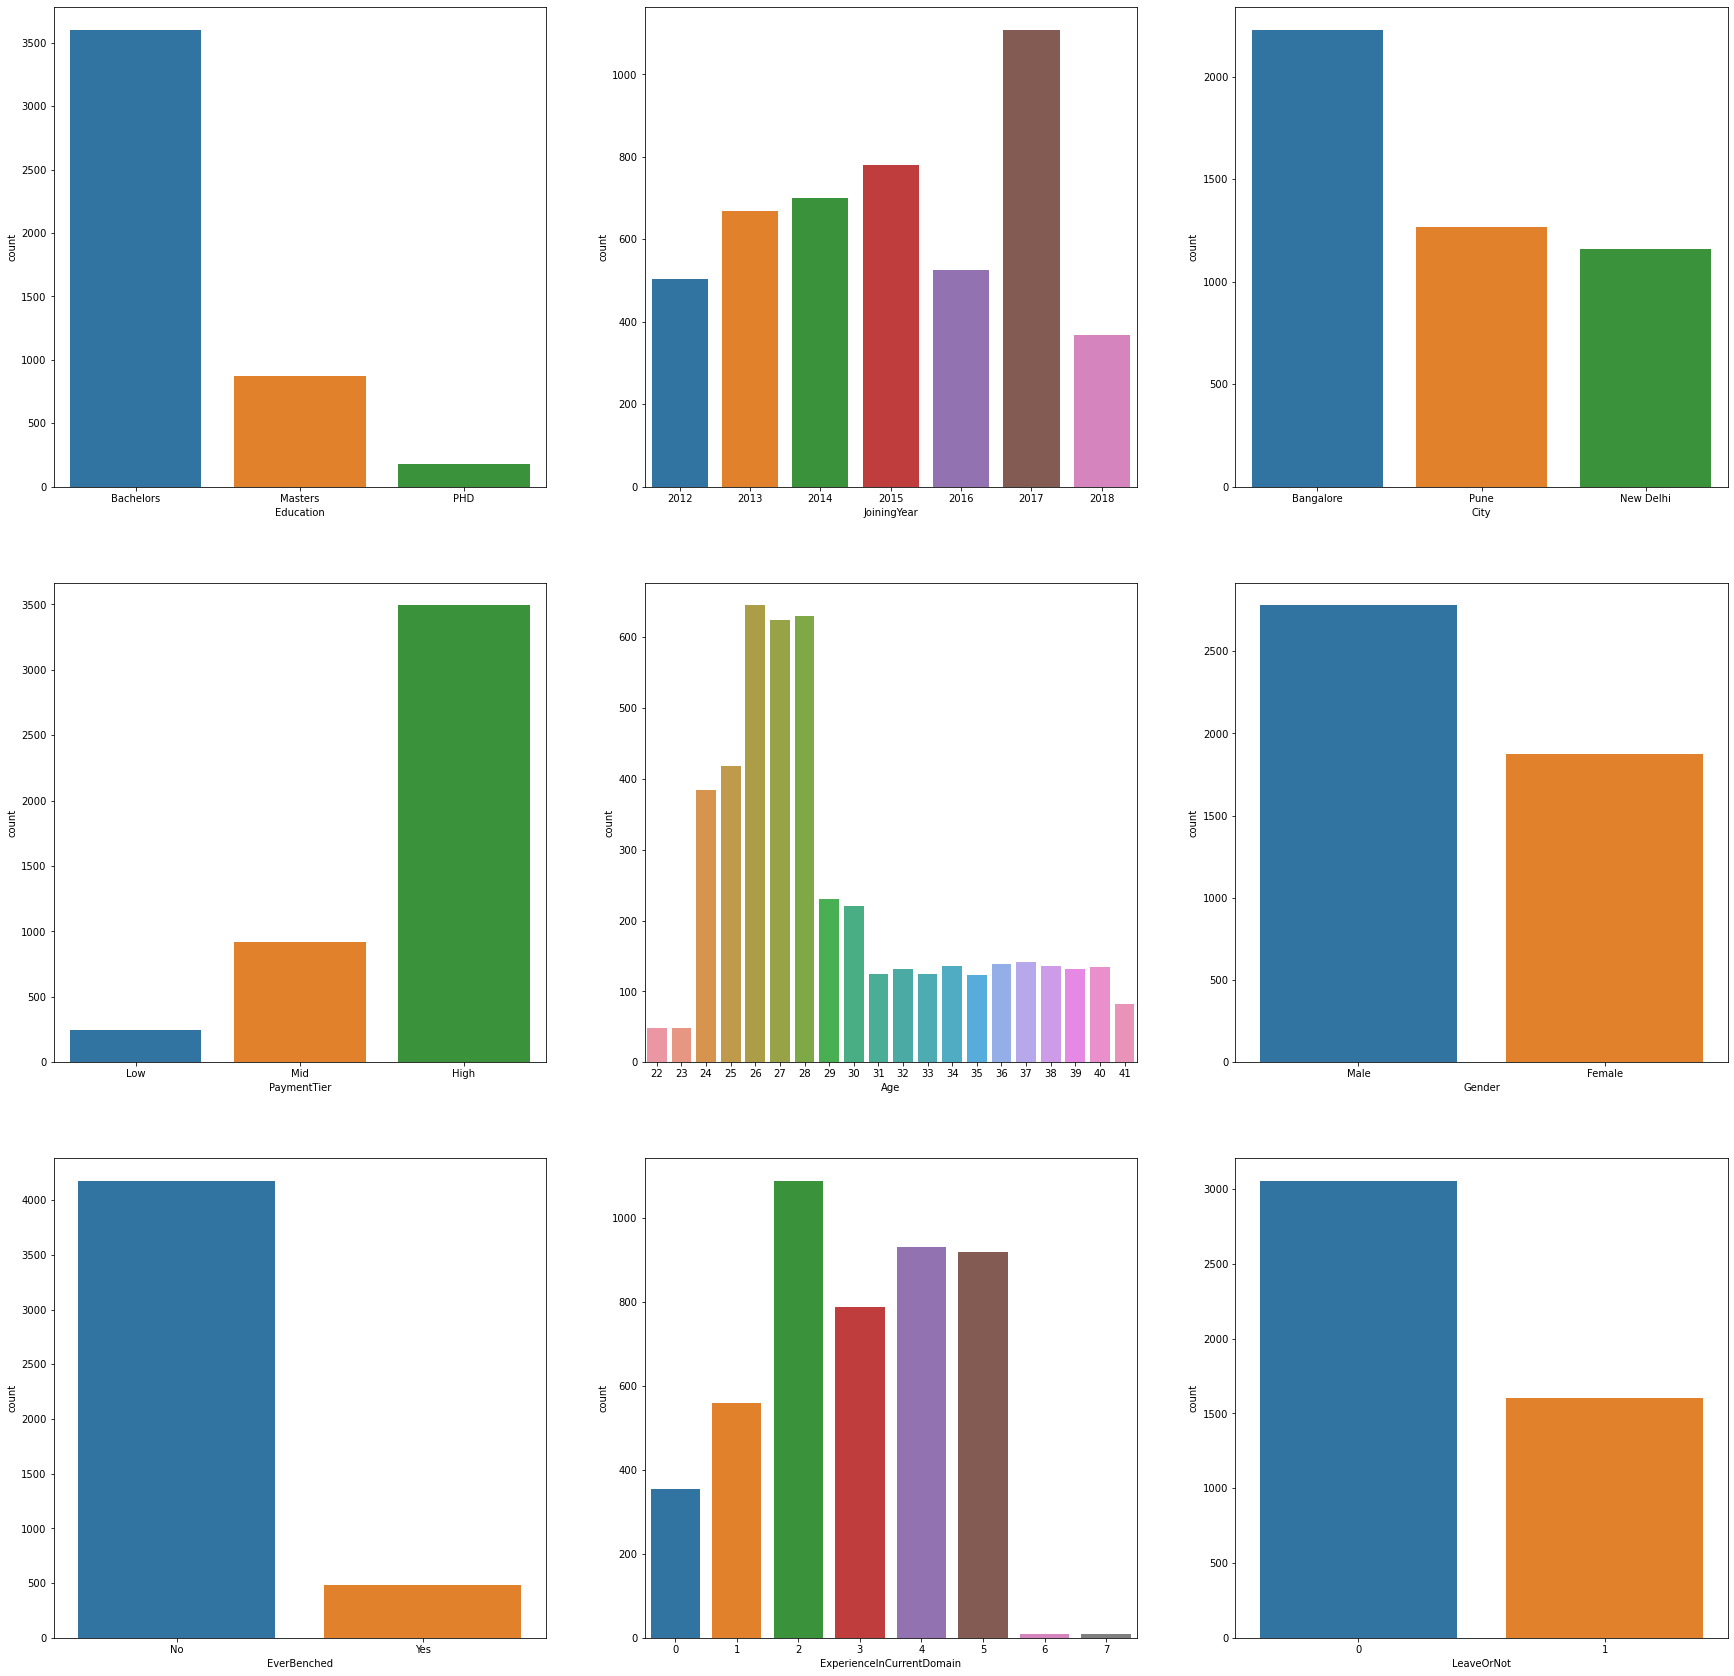

In [9]:
# bar plot 
n_plot(employee_dataset)

- **Variabili numeriche**: Dalla distribuzione delle frequenze per feature si può notare che la feature Age ha una distribuzione molto skew, la feature JoiningYear potrebbe essere quasi uniforme, mentre la feature ExperienceInCurrentDomain presente due frequenze molto basse per i valori 6 e 7
- **Variabile label**: Per la classe LeaveOrNot si può notare un rapporto quasi 2 a 1 per chi non lascia

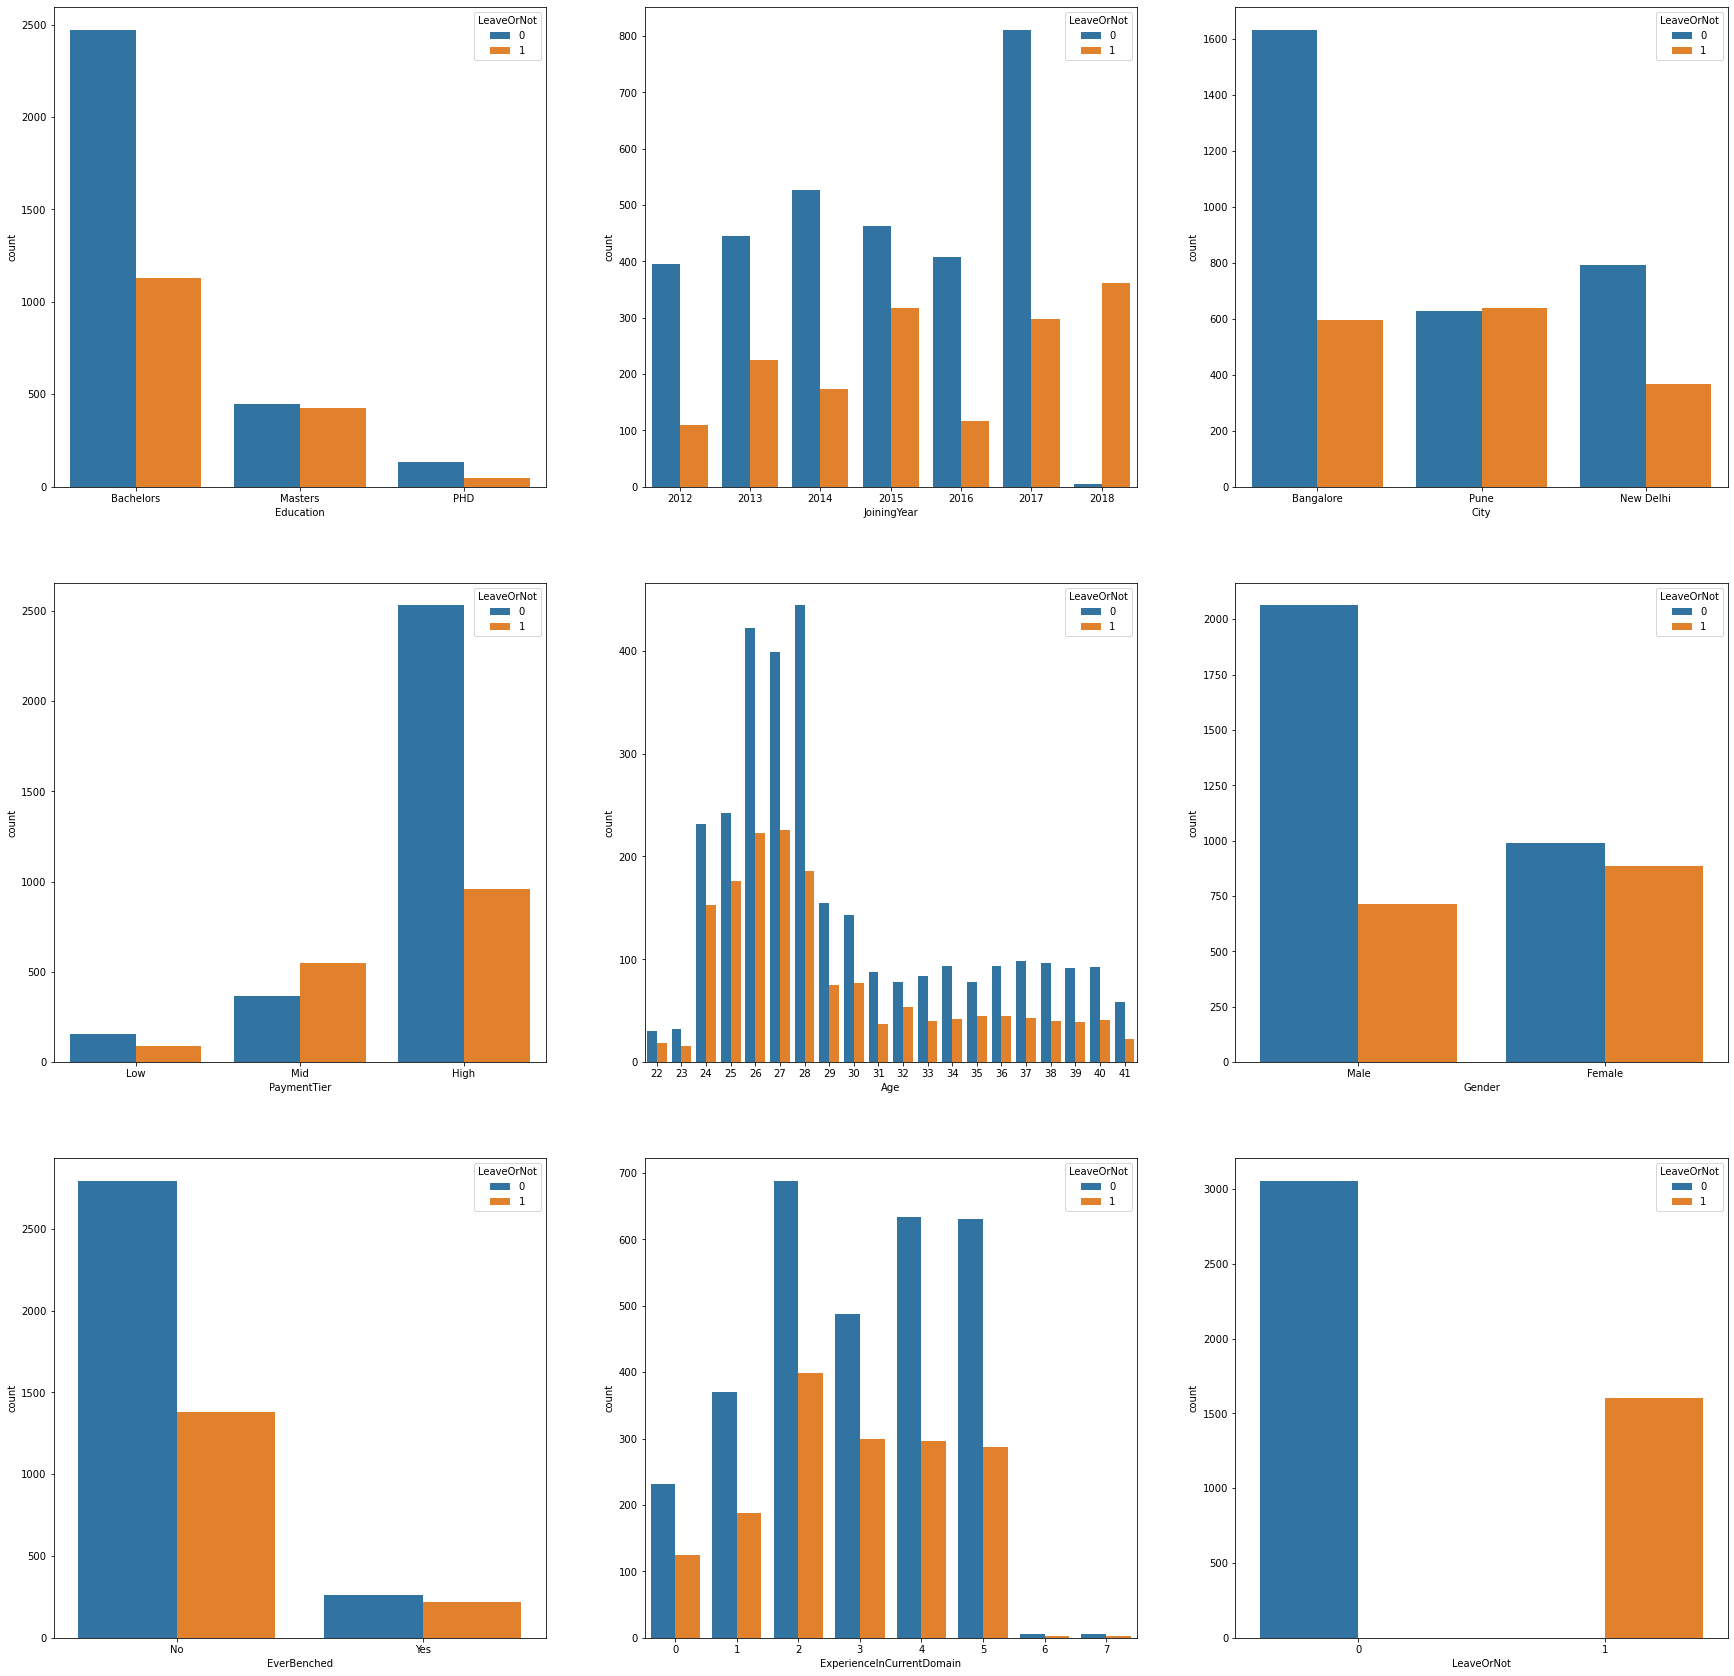

In [10]:
# multi bar plot
n_plot(employee_dataset, hue=employee_dataset["LeaveOrNot"])

- Dal multiple bar chart si può osservare la ripartizione delle frequenze ogni feature anche in riferimento alla variabile target
- Guardando la città di Pune si può notare che i dipendendi che lasciano sono di più rispetto ai dipendenti che lasciano 
- L'anno 2018 nella variabile JoiningYear mostra un numero molto alto di dipendenti che lasciano rispetto agli altri anni di assunzione
- La classe di stipendio Mid mostra più casi di abbandono rispetto alle altre classi
- Anche il genere potrebbe influire sull'abbandono

In [11]:
#  calcolo della tabella di contingenza per le variabili 'PaymentTier' e 'LeaveOrNot'
contigency= pd.crosstab(employee_dataset['PaymentTier'], employee_dataset['LeaveOrNot']) 

In [12]:
# test chi-quadrato per l'indipendenza, risultato molto significativo
c, p_value, dof, expected = chi2_contingency(contigency)
print(p_value)

2.93299047322625e-74


In [13]:
# estraggo colonna label
employee_label = employee_dataset.LeaveOrNot

In [14]:
# rimuovo dal dataset la label
employee_dataset.drop(columns= ['LeaveOrNot'], inplace=True)

In [15]:
# matrice di correlazione, le variabili non sembrano correlate (bassa correlazione)
matrice_correlazione = employee_dataset.corr()
matrice_correlazione

,JoiningYear,Age,ExperienceInCurrentDomain
JoiningYear,1.000000,0.013165,-0.036525
Age,0.013165,1.000000,-0.134643
ExperienceInCurrentDomain,-0.036525,-0.134643,1.000000


# 2. Trasformazione pipeline

- Utilizzo di diversi scaler per le variabili: età e anni di esperienza e anno di assunzione
- per la feature age si può notare una distribuzione skew quindi si utilizzerà una trasformazione robust scaler
- si può inferire dagli istogrammi delle frequenze che il robust scaler centra la moda a zero rispettando una distribuzione normale con presenza di skewness

In [16]:
# definisco gli scaler
std_scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [17]:
#applico gli scaler all'età
age_scaled = std_scaler.fit_transform(employee_dataset['Age'].values.reshape(-1,1))
age_robust =robust_scaler.fit_transform(employee_dataset['Age'].values.reshape(-1,1))
age_minmax = minmax_scaler.fit_transform(employee_dataset['Age'].values.reshape(-1,1))

(array([  97.,  803., 1270.,  860.,  345.,  256.,  259.,  280.,  267.,
         216.]),
 array([-1.53210856, -1.13837256, -0.74463656, -0.35090056,  0.04283544,
         0.43657144,  0.83030744,  1.22404345,  1.61777945,  2.01151545,
         2.40525145]),
 <BarContainer object of 10 artists>)

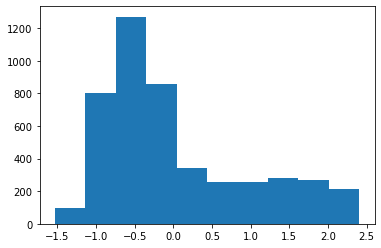

In [18]:
plt.hist(age_scaled)

(array([  97.,  803., 1270.,  860.,  345.,  256.,  259.,  280.,  267.,
         216.]),
 array([-1.        , -0.68333333, -0.36666667, -0.05      ,  0.26666667,
         0.58333333,  0.9       ,  1.21666667,  1.53333333,  1.85      ,
         2.16666667]),
 <BarContainer object of 10 artists>)

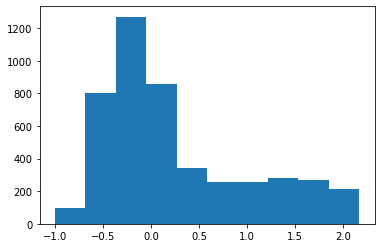

In [19]:
# dagli istogrammi si può notare che lo scaler robust centra il picco in 0, per questo è da preferire
plt.hist(age_robust)

(array([  97.,  803., 1270.,  860.,  345.,  256.,  259.,  280.,  267.,
         216.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

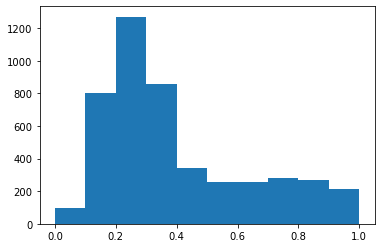

In [20]:
plt.hist(age_minmax)

In [21]:
# Per ExperienceInCurrentDomain si procederà con uno standard scaler, la distribuzione potrebbe essere ricondotta ad una normale
exp_scaled = std_scaler.fit_transform(employee_dataset['ExperienceInCurrentDomain'].values.reshape(-1,1))
exp_robust = robust_scaler.fit_transform(employee_dataset['ExperienceInCurrentDomain'].values.reshape(-1,1))

(array([ 355.,  558., 1087.,    0.,  786.,  931.,    0.,  919.,    8.,
           9.]),
 array([-1.5 , -1.15, -0.8 , -0.45, -0.1 ,  0.25,  0.6 ,  0.95,  1.3 ,
         1.65,  2.  ]),
 <BarContainer object of 10 artists>)

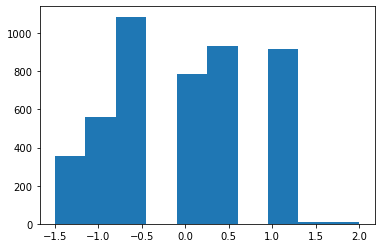

In [22]:
plt.hist(exp_robust)

(array([ 355.,  558., 1087.,    0.,  786.,  931.,    0.,  919.,    8.,
           9.]),
 array([-1.86490139, -1.41562843, -0.96635548, -0.51708253, -0.06780958,
         0.38146337,  0.83073632,  1.28000927,  1.72928223,  2.17855518,
         2.62782813]),
 <BarContainer object of 10 artists>)

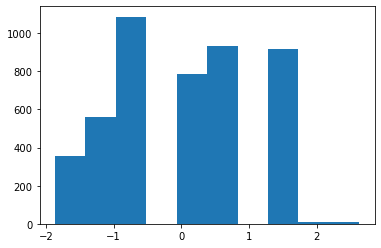

In [23]:
plt.hist(exp_scaled)

In [24]:
# per la feature joiningyear si può notare una distribuzione quasi uniforme quindi si utilizzerà una trasformazione min max scaler

In [25]:
# creazione della pipeline
# per variabili binarie utilizzo ordinal encoder
data_preprocessing = ColumnTransformer([
    ('education', OrdinalEncoder(categories=[['Bachelors', 'Masters','PHD']]), ['Education']),
    ('paymenttier', OrdinalEncoder(categories=[['Low', 'Mid', 'High']]), ['PaymentTier']),
    ('everbenched', OrdinalEncoder(categories=[['No', 'Yes']]), ['EverBenched']),
    ('gender', OrdinalEncoder(categories=[['Female', 'Male']]), ['Gender']),
    ('city', OneHotEncoder() , ['City']),
    ('age', robust_scaler, ['Age']),
    ('joining', minmax_scaler, ['JoiningYear']),
    ('exp', std_scaler, ['ExperienceInCurrentDomain']),

],
    remainder = 'passthrough'
)


In [26]:
# creazione daella matrice dei dati trasformata
feature_matrix = data_preprocessing.fit_transform(employee_dataset)

In [27]:
feature_matrix.shape

(4653, 10)

In [28]:
# creazione nuova lista delle colonne 
columns_name = ['Education','PaymentTier', 'EverBenched','Gender',  ]
columns_name.extend(['City_cat{}'.format(i) for i in range(1,len(employee_dataset['City'].unique())+1)])
columns_name.append('Age')
columns_name.append('JoiningYear')
columns_name.append('ExperienceInCurrentDomain')
columns_name

['Education',
 'PaymentTier',
 'EverBenched',
 'Gender',
 'City_cat1',
 'City_cat2',
 'City_cat3',
 'Age',
 'JoiningYear',
 'ExperienceInCurrentDomain']

In [29]:
data_preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('education',
                                 OrdinalEncoder(categories=[['Bachelors',
                                                             'Masters',
                                                             'PHD']]),
                                 ['Education']),
                                ('paymenttier',
                                 OrdinalEncoder(categories=[['Low', 'Mid',
                                                             'High']]),
                                 ['PaymentTier']),
                                ('everbenched',
                                 OrdinalEncoder(categories=[['No', 'Yes']]),
                                 ['EverBenched']),
                                ('gender',
                                 OrdinalEncoder(categories=[['Female',
                                                             'Male']]),
                                 ['Ge

In [30]:
# salvo i dati processati
with open('data/feature_matrix.pickle', 'wb') as s:
    pickle.dump(feature_matrix, s)

In [31]:
with open('data/columns_name.pickle', 'wb') as s:
    pickle.dump(columns_name, s)

In [32]:
with open('data/employee_label.pickle', 'wb') as s:
    pickle.dump(employee_label, s)